In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Weignt-normalized Complement Naive Bayes code
## Apply the tf-idf term weighting
##### Student ID: 2109853M-IM20-0015
##### This code includes Weignt-normalized Complement Naive Bayes.(Question3)

In [12]:
def preprocess(str_arg):
    cleaned_str = re.sub('[^a-z\s]+', ' ', str_arg, flags=re.IGNORECASE)
    cleaned_str = re.sub('(\s+)', ' ', cleaned_str)
    cleaned_str = cleaned_str.lower()
    cleaned_str = cleaned_str.strip()
    return cleaned_str

In [13]:
class TWCNB:

    def __init__(self, unique_classes):
        self.classes = unique_classes
        self.bow_dicts = np.array([defaultdict(lambda: 0) for index in range(self.classes.shape[0])])

    def addToword(self, example, dict_index):
        if isinstance(example, np.ndarray): example = example[0]
        for token_word in example.split():
            self.bow_dicts[dict_index][token_word] += 1

    def Train(self, dataset, labels):
        self.examples = dataset
        self.labels = labels

        if not isinstance(self.examples, np.ndarray): self.examples = np.array(self.examples)
        if not isinstance(self.labels, np.ndarray): self.labels = np.array(self.labels)

        # constructing the-bag-of-word for each category
        for category_index, category in enumerate(tqdm(self.classes, desc='Calculate probability for each category')):
            all_category = self.examples[self.labels == category]
            cleaned_examples = [preprocess(cat) for cat in all_category]
            cleaned_examples = pd.DataFrame(data=cleaned_examples)

            np.apply_along_axis(self.addToword, 1, cleaned_examples, category_index)

        prob_classes = np.empty(self.classes.shape[0])
        all_words = []
        cat_word_counts = np.empty(self.classes.shape[0])
        total = 0
        for category_index, category in enumerate(self.classes):
            # Calculating prior probability p(c) for each class
            prob_classes[category_index] = np.sum(self.labels == category) / float(self.labels.shape[0])
            count = list(self.bow_dicts[category_index].values())
            cat_word_counts[category_index] = np.sum(
                np.array(list(self.bow_dicts[category_index].values()))) + 1  # |v|
            total += cat_word_counts[category_index]
            # get all words of this category
            all_words += self.bow_dicts[category_index].keys()

        self.vocabulary = np.unique(np.array(all_words))
        self.vocab_length = self.vocabulary.shape[0]

        # computing denominator value
        denoms = np.array([total - cat_word_counts[cat_index] for cat_index, cat in enumerate(self.classes)])
        self.cats_info = [(self.bow_dicts[cat_index], prob_classes[cat_index], denoms[cat_index]) for cat_index, cat in
                          enumerate(self.classes)]
        self.cats_info = np.array(self.cats_info)
        self.wc_count = np.ones((self.classes.shape[0], self.vocabulary.shape[0]))
        for cl_ind, cl in enumerate(self.classes):
            cl_count = 1
            for i, w in enumerate(self.vocabulary):
                count = 1
                for comp_cl_ind, comp_cl in enumerate(self.classes):
                    if comp_cl != cl:
                        count += self.cats_info[comp_cl_ind][0].get(w, 0)
                self.wc_count[cl_ind][i] = np.log(count / float(denoms[cl_ind]))
                cl_count += abs(np.log(count / float(denoms[cl_ind])))
            self.wc_count[cl_ind] = self.wc_count[cl_ind] / float(cl_count)
    def probability(self, test_example):
        likelihood_prob = np.zeros(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            for test_token in test_example.split():
                w_ind = np.where(self.vocabulary == test_token)[0]
                if len(w_ind) > 0:
                    likelihood_prob[cat_index] += self.wc_count[cat_index][int(w_ind)]

        post_prob = np.empty(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            post_prob[cat_index] = -likelihood_prob[cat_index]
        return post_prob
    def Test(self, test_set):
        predictions = []
        for example in tqdm(test_set, desc='Test'):
            cleaned_example = preprocess(example)
            post_prob = self.probability(cleaned_example)
            predictions.append(self.classes[np.argmax(post_prob)])

        return np.array(predictions)

## Test result(accuracy)

In [14]:
newsgroups_train = fetch_20newsgroups(subset='train')
train_data = newsgroups_train.data
train_labels = newsgroups_train.target
print('Successful load train set')
newsgroups_test = fetch_20newsgroups(subset='test')
test_data = newsgroups_test.data
test_labels = newsgroups_test.target
print('Successful load test set')
cnb = TWCNB(np.unique(train_labels))
cnb.Train(train_data, train_labels)
print('End train')
pclasses = cnb.Test(test_data)
print('End test')
test_acc = np.sum(pclasses == test_labels) / float(test_labels.shape[0])

print("Test Set Examples: ", test_labels.shape[0])
print("Test Set Accuracy: ", test_acc * 100, "%")

Successful load train set
Successful load test set


Test:   0%|          | 0/7532 [00:00<?, ?it/s]

End train


Test: 100%|██████████| 7532/7532 [9:58:32<00:00,  4.77s/it]     

End test
Test Set Examples:  7532
Test Set Accuracy:  80.74880509824747 %


## Confusion matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.PuBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()

[[0.79 0.   0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.02
  0.02 0.1  0.01 0.02 0.   0.01]
 [0.   0.74 0.02 0.04 0.02 0.07 0.   0.01 0.   0.01 0.02 0.03 0.02 0.
  0.02 0.   0.01 0.01 0.01 0.  ]
 [0.01 0.06 0.22 0.25 0.04 0.19 0.01 0.01 0.01 0.01 0.02 0.05 0.01 0.01
  0.02 0.03 0.   0.   0.05 0.  ]
 [0.01 0.02 0.02 0.78 0.04 0.02 0.02 0.01 0.   0.   0.   0.03 0.03 0.
  0.02 0.01 0.   0.   0.   0.  ]
 [0.01 0.02 0.   0.08 0.79 0.01 0.01 0.01 0.   0.01 0.   0.01 0.02 0.
  0.01 0.01 0.01 0.   0.02 0.  ]
 [0.   0.04 0.01 0.01 0.01 0.88 0.   0.   0.   0.   0.01 0.02 0.   0.
  0.01 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.01 0.13 0.03 0.01 0.65 0.04 0.02 0.01 0.01 0.   0.03 0.02
  0.01 0.01 0.01 0.   0.01 0.  ]
 [0.   0.   0.01 0.02 0.01 0.   0.01 0.91 0.01 0.01 0.   0.   0.01 0.
  0.   0.   0.01 0.   0.01 0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.02 0.97 0.   0.   0.   0.01 0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.01 0.   0.94 0.04 0.   0.   

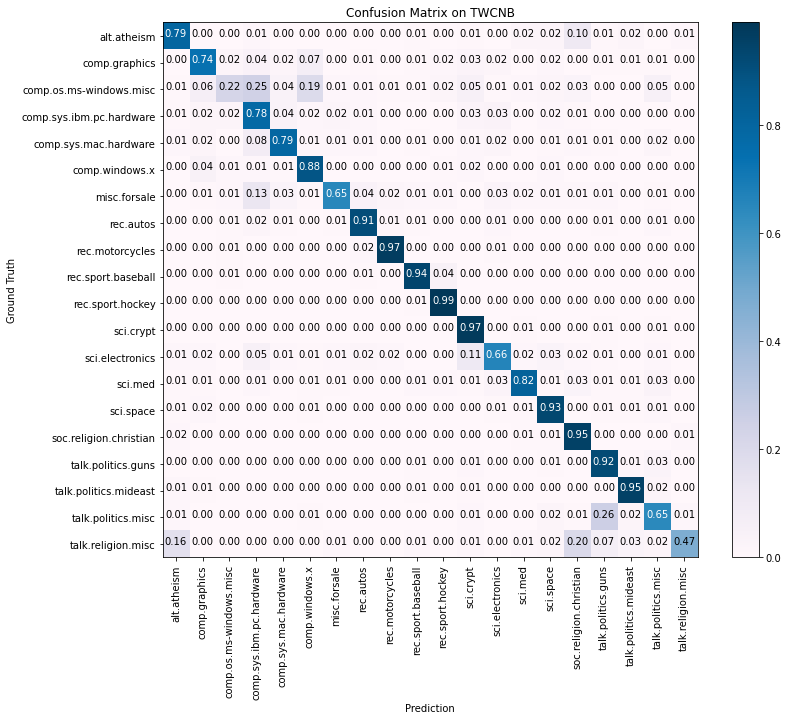

In [22]:
# Compute confusion matrix
cma = confusion_matrix(test_labels, pclasses, labels=None, sample_weight=None)
# cnf_matrix = confusion_matrix(test_label, predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 10), facecolor='w', edgecolor='b')
plot_confusion_matrix(cma, classes=newsgroups_test.target_names,
                      title='Confusion Matrix on TWCNB')
plt.savefig('TWCNB.png')